# **Credit Risk Project**

Every company in the financial sector shares a fundamental objective: to grant credit to customers to stimulate consumption and, consequently, increase their own profits. However, this process needs to be balanced with the need to mitigate risks, such as default and fraud, which can compromise the organization's financial health.

To achieve this balance, companies adopt several strategies and advanced technologies. Credit analysis, for example, is an essential tool in this context. Through it, institutions evaluate the customer's profile based on their financial history, income, payment behavior, and other factors that may indicate their ability to honor financial commitments. With the advancement of technology, many of these processes are automated, using artificial intelligence and machine learning to predict risks more accurately.

In addition to credit analysis, companies implement robust security systems to prevent fraud. Methods such as multi-factor authentication, user behavior analysis, and continuous transaction monitoring help identify suspicious activity before it can cause significant damage.

Another common approach is to diversify credit offerings, creating customized products according to the risk profile of each customer. Credit cards with different limits, loans with collateral, and adapted financing are some of the ways to balance credit granting with protection against default.

The financial sector is constantly evolving to optimize this process, ensuring that credit is granted in a sustainable way for both the customer and the company. In this way, a safe and profitable environment is sought, where consumption is encouraged without compromising the financial stability of institutions.

This project aims to construct a machine learn model to predict the score credit. In this context, we will classify a new customer as: well payed (class: 0), default (class: 1). For this we need to construct a model based in this two points:

* **Reduce the rate of false positives** - that is, reduce the number of cases in which the model points to the customer as a bad payer but is actually a good payer

* **Decrease the rate of false negatives** - that is, reduce the number of cases in which the model points to the customer as a good payer when, in fact, it is a bad payer.

For us, it's more interesting the second option, because cause financial more impactness to the companies.



## **1- Exploring Dataset**

In [3]:
#import libraries

#data manipulation
import pandas as pd
import numpy as np
from typing import List
import math

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#hypothesis test
from scipy.stats import levene, f_oneway

#pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

#metrics to evaluate models
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix


In [7]:
#reading csv file
df_original = pd.read_csv("..\\data\\risco_credito.csv")
df = df_original.copy()

In [8]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 1000
Number of columns: 10


* **Visualize the first rows.**

In [9]:
df.head()

,Idade,Renda,Score,hist_inadim_meses,valor_emprestimo,relacao_dividarenda,classe_emprego,possui_imovel,possui_veiculo,inadimplente
0,56,7882,520,1,32586,55.29,CLT,1,0,0
1,69,2906,453,10,22568,15.18,CLT,1,0,1
2,46,4086,311,5,25810,9.28,Desempregado,0,0,1
3,32,14503,432,11,6551,61.81,Autônomo,0,1,1
4,60,9152,603,5,17625,25.59,Autônomo,1,1,0


* **Columns Dictionary:**

* `Idade`: the customer age
* `Renda`: Their salary
* `Score`: It's a score for credit based on the features. Higher credit scores mean low risk of default
* `hist_inadim_meses`: Total months of default.
* `valor_emprestimo`: Amount of loan granted to the customer
* `relacao_dividarenda`: Debt-to-income ratio
* `classe_emprego`: Type of employment
* `possui_imovel`: if the costumer has properties
* `possui_veiculo`:  if the customer has vehicles
* `inadimplente`: target (if is default or not)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Idade                1000 non-null   int64  
 1   Renda                1000 non-null   int64  
 2   Score                1000 non-null   int64  
 3   hist_inadim_meses    1000 non-null   int64  
 4   valor_emprestimo     1000 non-null   int64  
 5   relacao_dividarenda  1000 non-null   float64
 6   classe_emprego       1000 non-null   object 
 7   possui_imovel        1000 non-null   int64  
 8   possui_veiculo       1000 non-null   int64  
 9   inadimplente         1000 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 78.3+ KB


All the features are in the correct data types and there is no missing values. We'll chack about duplicates.

In [11]:
print(f"Number of duplicates: {df.duplicated().sum()}\n")
print(f"Number of missing values:\n{df.isnull().sum()}")

Number of duplicates: 0

Number of missing values:
Idade                  0
Renda                  0
Score                  0
hist_inadim_meses      0
valor_emprestimo       0
relacao_dividarenda    0
classe_emprego         0
possui_imovel          0
possui_veiculo         0
inadimplente           0
dtype: int64


## **2- Exploratory Analisis**

### **2.1- Univariate Analysis**

* **Numerical Features**

In [12]:
df.describe()

,Idade,Renda,Score,hist_inadim_meses,valor_emprestimo,relacao_dividarenda,possui_imovel,possui_veiculo,inadimplente
count,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,43.81900,10386.46400,582.536000,5.453000,27605.870000,39.873530,0.404000,0.524000,0.313000
std,14.99103,5498.67584,156.540313,3.460891,12887.411945,19.424799,0.490943,0.499674,0.463946
min,18.00000,1009.00000,300.000000,0.000000,5136.000000,0.000000,0.000000,0.000000,0.000000
25%,31.00000,5590.75000,447.000000,2.000000,16339.750000,26.632500,0.000000,0.000000,0.000000
50%,44.00000,10203.00000,582.000000,5.000000,28273.500000,39.055000,0.000000,1.000000,0.000000
75%,56.00000,15037.75000,721.000000,8.000000,38594.250000,53.460000,1.000000,1.000000,1.000000
max,69.00000,19988.00000,849.000000,11.000000,49993.000000,100.000000,1.000000,1.000000,1.000000


In [13]:
from ast import Str
def plot_histogram(df: pd.DataFrame, features: List[str]):
  """
    Function to plot histogram for continuos categories

    Parameters:
    df : Dataframe
    features : List of features to plot

    Returns:
    None
  """
  cols = 3
  rows = math.ceil(len(features) / cols)  # number of rows will be necessary

  fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))  # Define the plot size
  axes = axes.flatten()  # Transform the axis matrix into array

  for i, feature in enumerate(features):
      axes[i].hist(df[feature], bins=30, edgecolor="black", color = 'lightsteelblue')
      axes[i].set_title(f"Histogram for {feature}")
      axes[i].set_xlabel(feature)
      axes[i].set_ylabel("Frequency")

    # remove the empty plots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

C:\Users\vanes\AppData\Local\Temp\ipykernel_85612\3316169793.py:1: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  from ast import Str


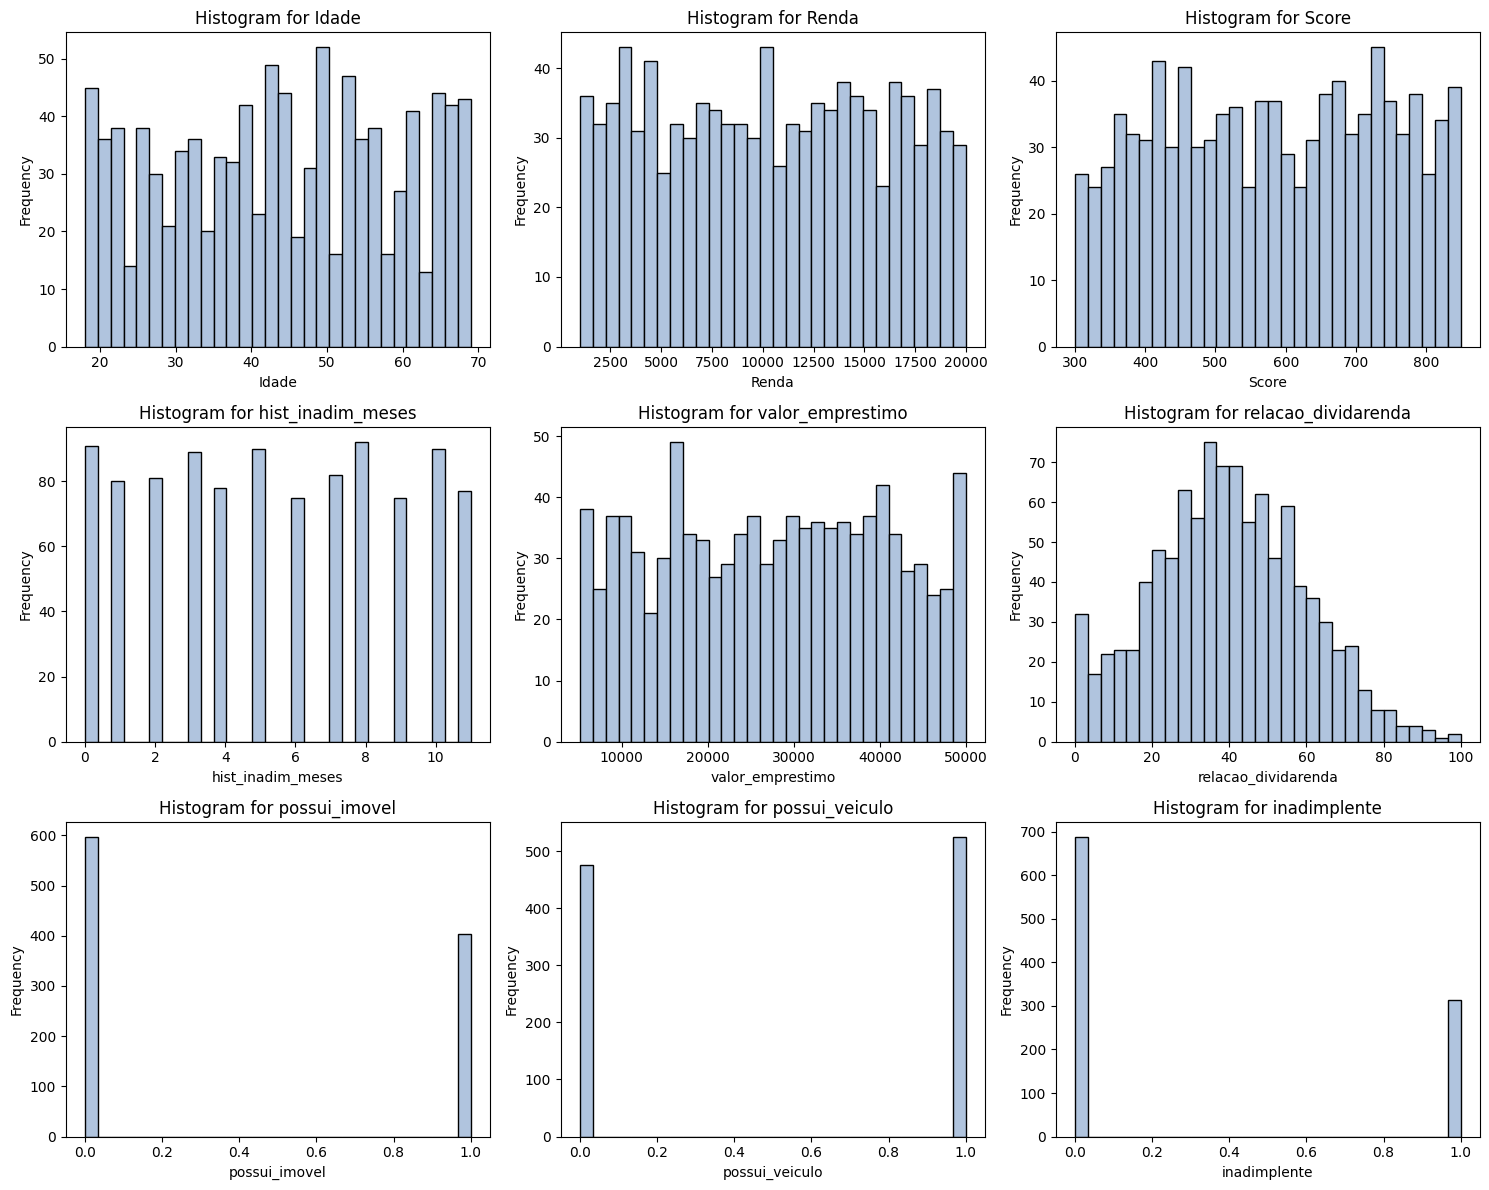

In [14]:
# plot histogram graphs
numerical_columns = df.select_dtypes(include = np.number).columns.to_list()
plot_histogram(df, numerical_columns)

In [15]:
# Function to plot a boxplot to all features
def plot_boxplot(df: pd.DataFrame, features: List[str]):
  """
    Function to plot boxplot for continuos
    Parameters:
    df : Dataframe

    Returns:
    None
  """
  cols = 3
  rows = math.ceil(len(features) / cols)  # number of rows will be necessary

  fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))  # Define the plot size
  axes = axes.flatten()  # Transform a matrix axis into array

  for i, feature in enumerate(features):
      axes[i].boxplot(
            df[feature].dropna(),
            patch_artist=True,  # It's necessary to color
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(markerfacecolor='orange', marker='o', markersize=5, linestyle='none')
        )
      axes[i].set_title(f"Boxplot for {feature}")
      axes[i].set_xlabel(feature)
      axes[i].set_ylabel("Distribution")
      axes[i].grid(axis="y", alpha=0.75)

    # Remove empty plots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


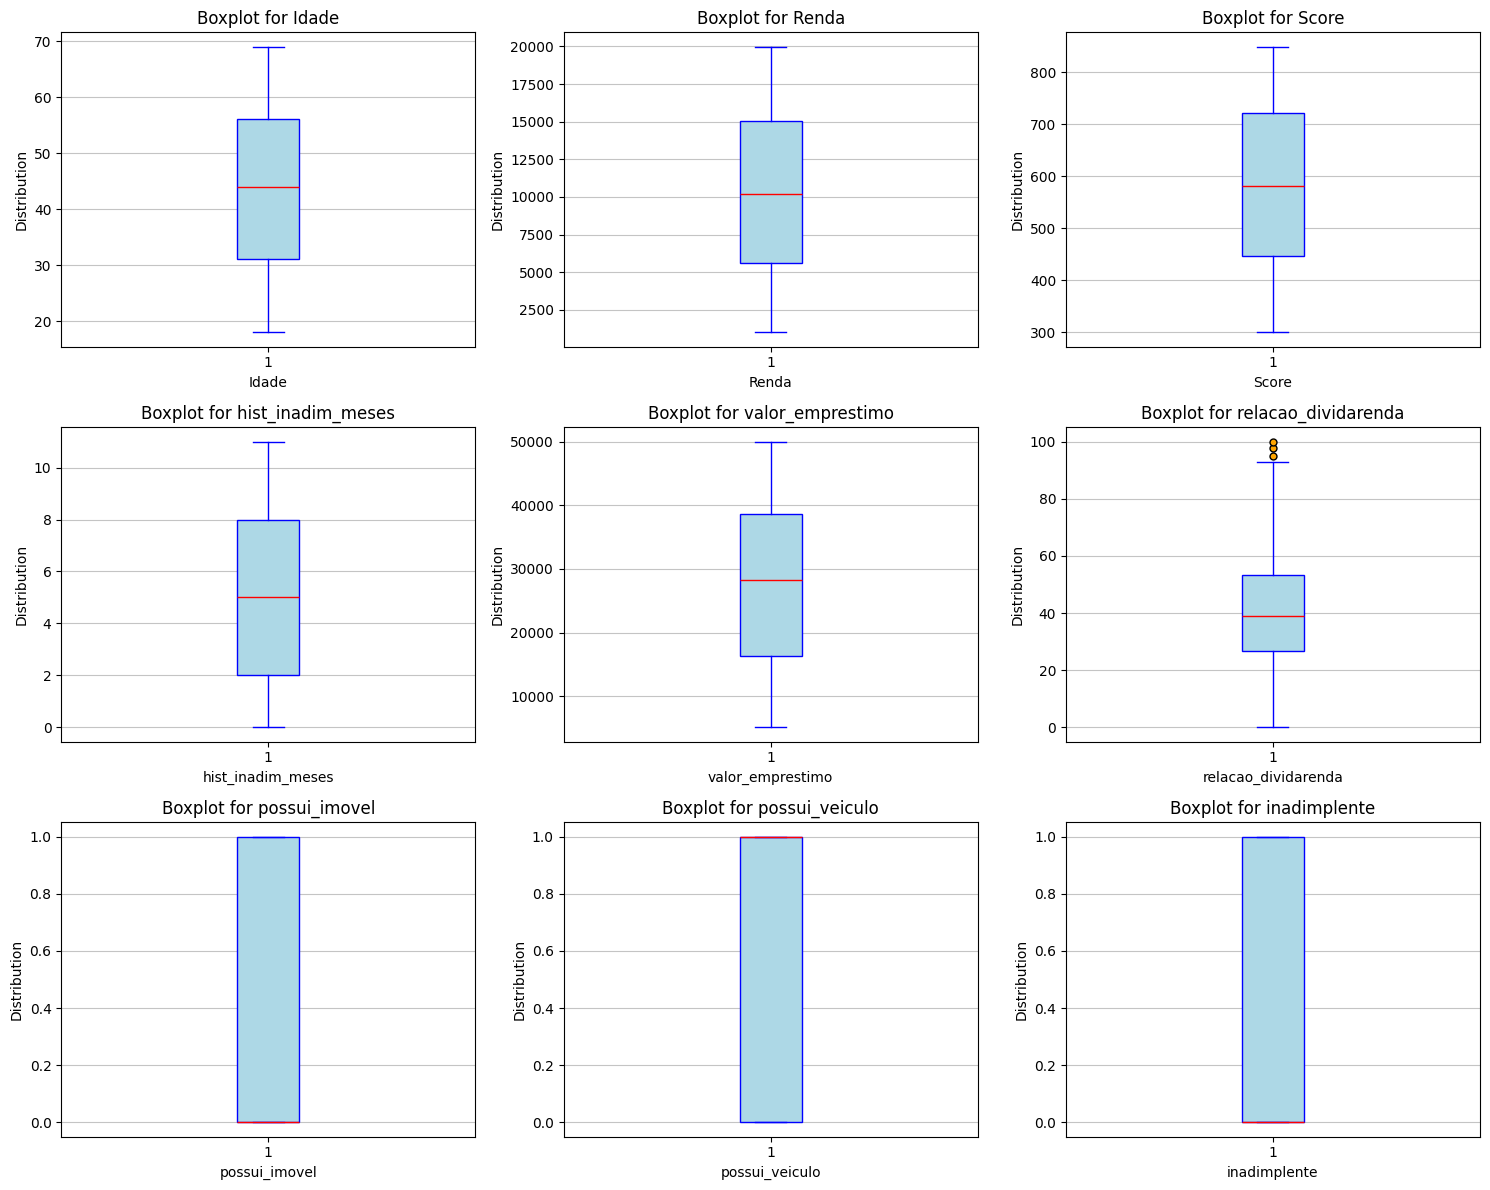

In [16]:
plot_boxplot(df, numerical_columns)

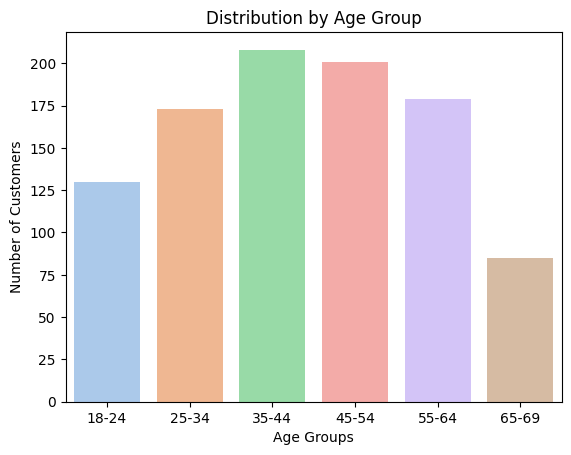

In [17]:
bins = [18, 25, 35, 45, 55, 65, 69]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-69']
df['faixa_etaria'] = pd.cut(df['Idade'], bins=bins, labels=labels, right=True)


sns.countplot(data=df, x='faixa_etaria', hue='faixa_etaria', legend=False, palette='pastel')
plt.title('Distribution by Age Group')
plt.xlabel('Age Groups')
plt.ylabel('Number of Customers')
plt.show()



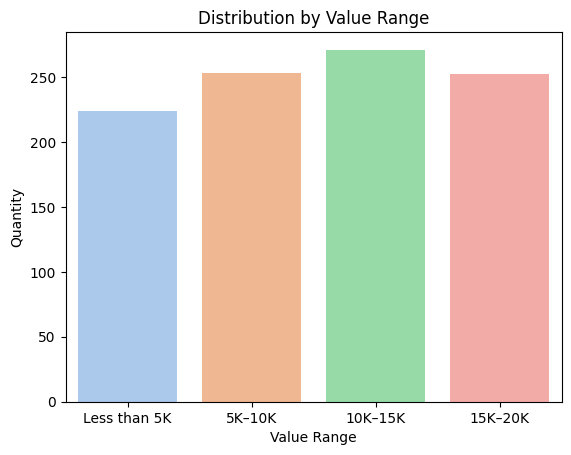

In [18]:
bins = [0, 5000, 10000, 15000, 20000]
labels = ['Less than 5K', '5K–10K', '10K–15K', '15K–20K']
df['faixa_valor'] = pd.cut(df['Renda'], bins=bins, labels=labels)

sns.countplot(data=df, x='faixa_valor', hue='faixa_valor', legend=False, palette='pastel')
plt.title('Distribution by Value Range')
plt.xlabel('Value Range')
plt.ylabel('Quantity')
plt.show()


In [19]:
df.Renda.describe()

count     1000.00000
mean     10386.46400
std       5498.67584
min       1009.00000
25%       5590.75000
50%      10203.00000
75%      15037.75000
max      19988.00000
Name: Renda, dtype: float64

In general, we have clients with different ages ranging from 18 to 70 years old, with a standard deviation of 14. Therefore, we have clients with different profiles. Likewise, we have clients with very different salary ranges. We can see that there are clients with a salary of 1000 dollars, and clients who reach almost 20k. This raises some hypotheses:

1. **Do clients with higher performance have a higher score?**

2. **Do clients with lower salaries have a shorter period of default?**



- **Categorical features**

In [20]:
df['classe_emprego'].value_counts()

classe_emprego
CLT             566
Autônomo        333
Desempregado    101
Name: count, dtype: int64

In [21]:
#barplot to categorical feature
def plot_barplot(df: pd.DataFrame, features: List[str]):
  """
    Function to plot barplot for categorical features

    Parameters:
    df : Dataframe
    features : List of features to plot

    Returns:
    None
    """
  cols = 3
  rows = math.ceil(len(features) / cols)
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
  axes = axes.flatten()

  for i, feature in enumerate(features):
      sns.countplot(data=df, x=feature, hue=feature, legend=False, palette='pastel', ax=axes[i])
      axes[i].set_title(f"Barplot for {feature}")
      axes[i].set_xlabel(feature)
      axes[i].set_ylabel("Frequency")

  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()
  return None


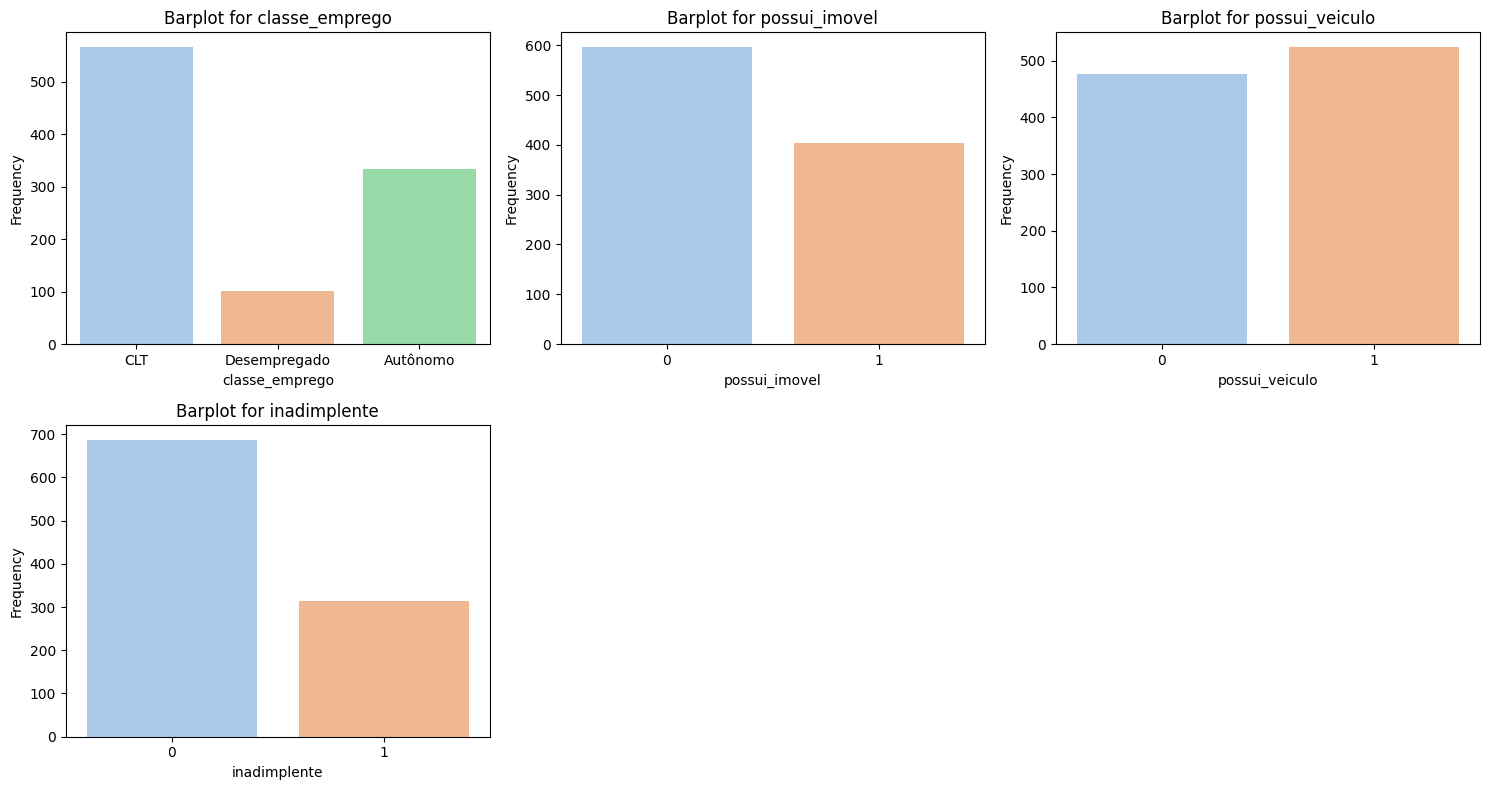

In [22]:
plot_barplot(df, ['classe_emprego', 'possui_imovel', 'possui_veiculo', 'inadimplente'])

### **2.2- Bivariate Analysis**

Here we are interested in analyzing the correlation between features with the target and checking if some features have correlation with others.

* **Correlation matrix**

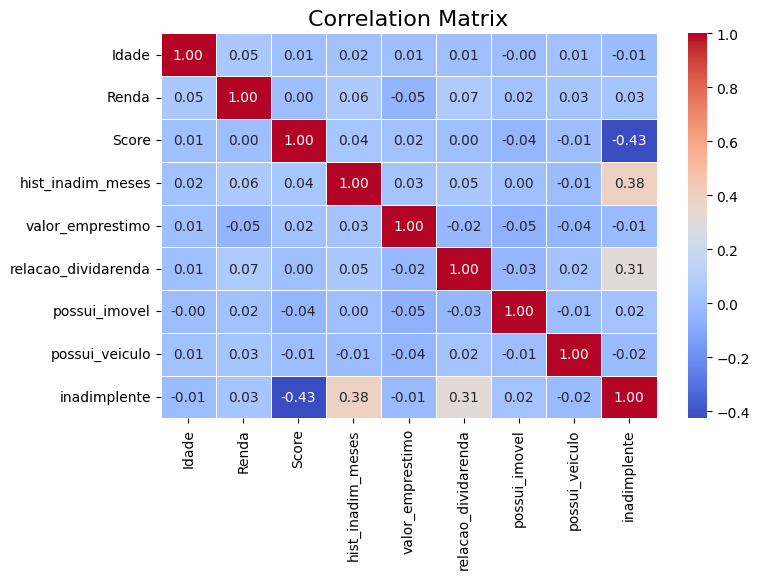

In [23]:
# Select only numerical features
numerics = df.select_dtypes(include=np.number)

#Calculate the correlation matrix
correlation_matrix = numerics.corr()

#Plot the heatmap with color gradient

plt.figure(figsize=(8,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()


There aren't any feature with strong correlation with others. Even strong correlations with the target.

* **Features vs Target**

<Axes: xlabel='inadimplente', ylabel='Score'>

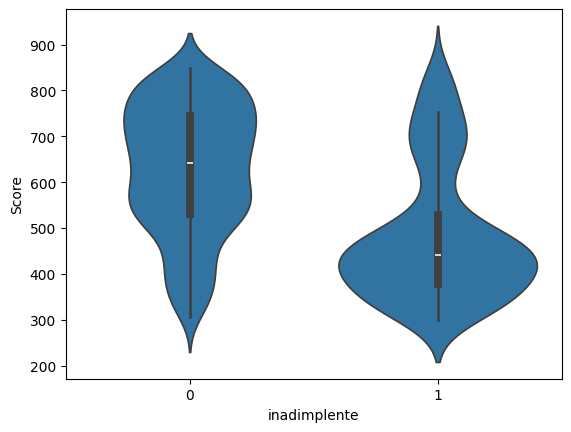

In [24]:
sns.violinplot(data=df, x='inadimplente', y='Score')

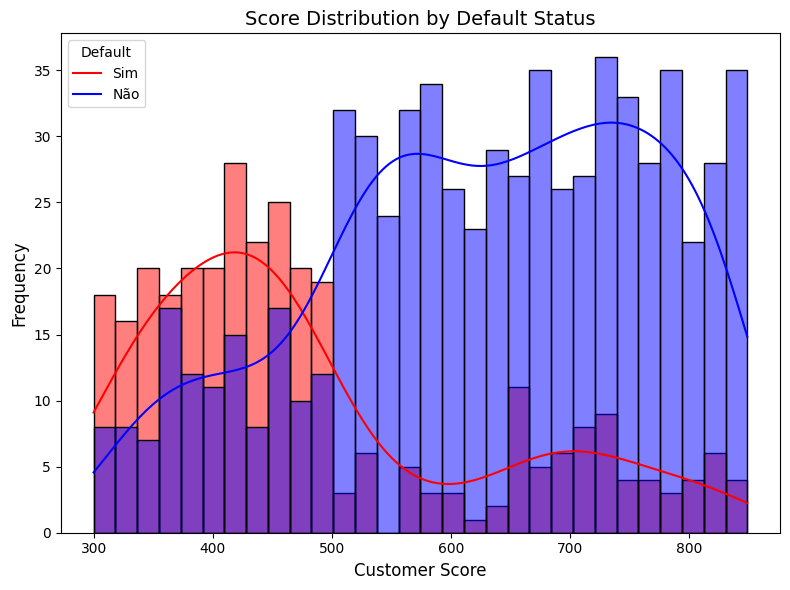

In [25]:
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x='Score',
    hue='inadimplente',
    kde=True,
    bins=30,
    palette={0: 'blue', 1: 'red'},
    alpha=0.5
)

plt.title('Score Distribution by Default Status', fontsize=14)
plt.xlabel('Customer Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Default', labels=['Sim', 'Não'])
plt.tight_layout()
plt.show()

We have a higher concentration of non-defaulting customers with high scores, which is expected. In addition, there are some customers with a high score who still defaulted, so it's possible that decide if some customer will be default only by their score, it's not the best option because it doesn't separe the two groups very well.

* **Age Range by default**

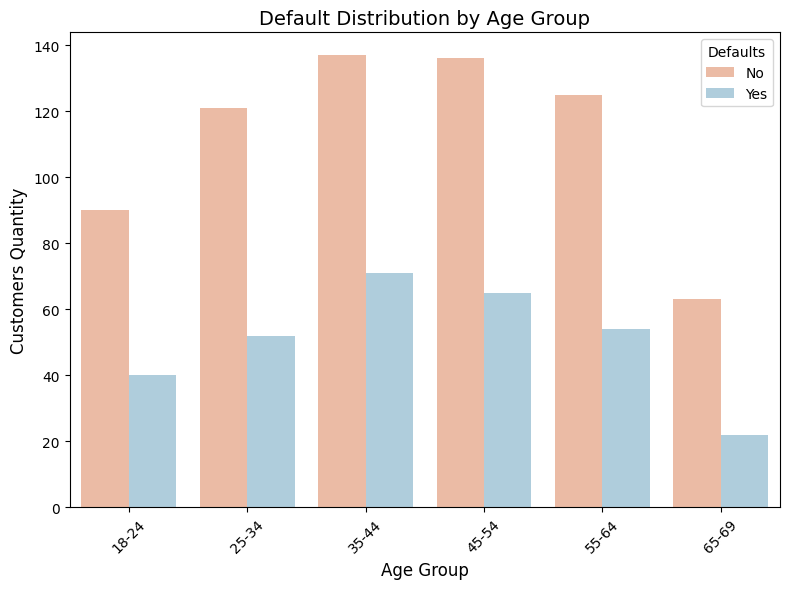

In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='faixa_etaria', hue='inadimplente', palette='RdBu')

plt.title('Default Distribution by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Customers Quantity', fontsize=12)
plt.legend(title='Defaults', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\vanes\AppData\Local\Temp\ipykernel_85612\3726278748.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby('faixa_etaria')['inadimplente'].mean().reset_index()


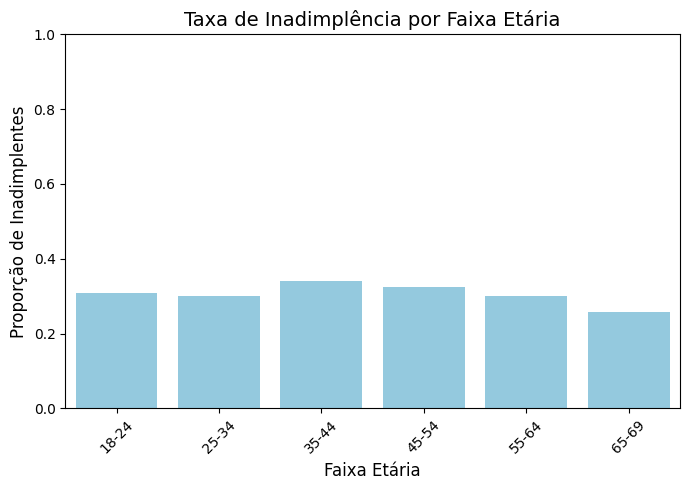

In [28]:
# Calcula a taxa de inadimplência por faixa etária
df_grouped = df.groupby('faixa_etaria')['inadimplente'].mean().reset_index()

plt.figure(figsize=(7, 5))
sns.barplot(data=df_grouped, x='faixa_etaria', y='inadimplente', color='skyblue')

plt.title('Taxa de Inadimplência por Faixa Etária', fontsize=14)
plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Proporção de Inadimplentes', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* **Default by Type of employment**

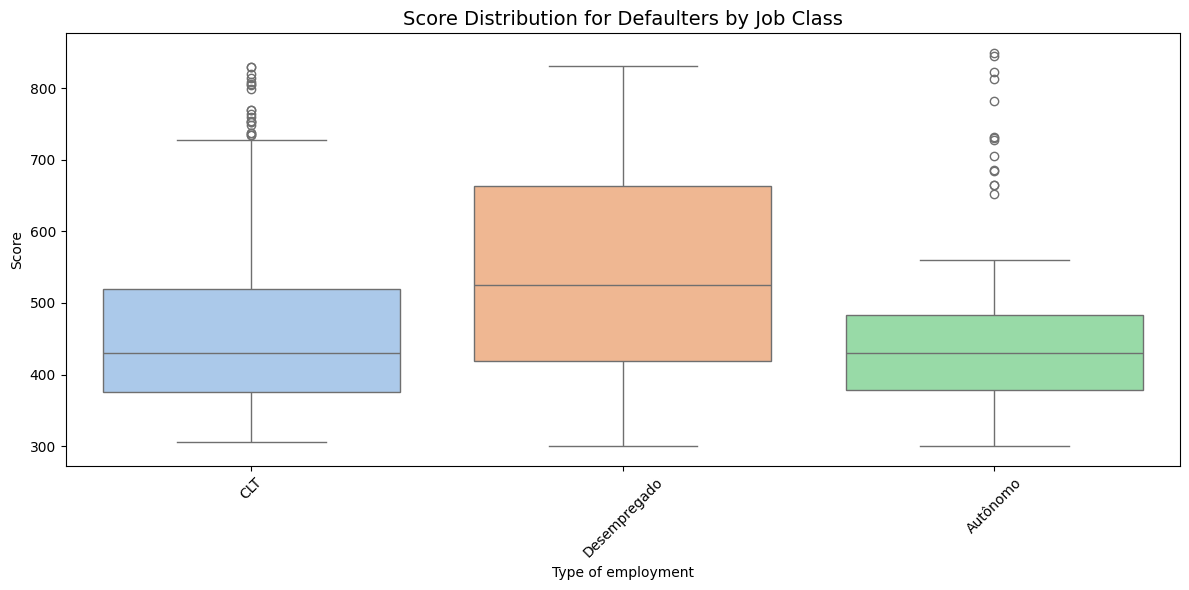

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df[df['inadimplente'] == 1],
    x='classe_emprego',
    y='Score',
    palette='pastel',
    hue='classe_emprego'
)

plt.title('Score Distribution for Defaulters by Job Class', fontsize=14)
plt.xlabel('Type of employment')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



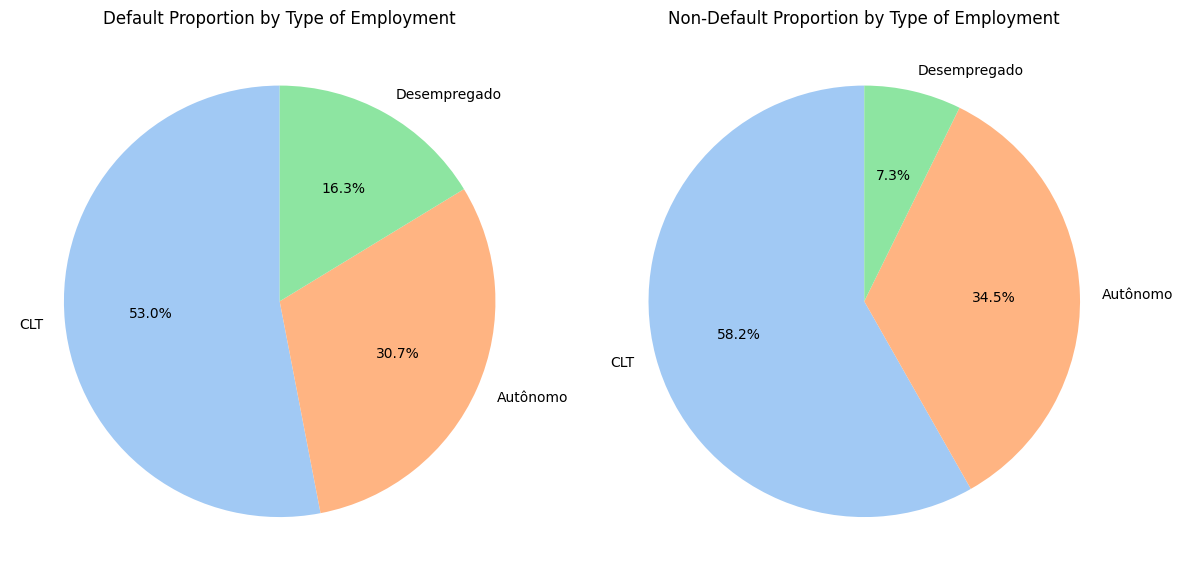

In [30]:
proportion_default = df[df['inadimplente']==1]['classe_emprego'].value_counts(normalize=True)
proportion_non_default = df[df['inadimplente']==0]['classe_emprego'].value_counts(normalize=True)

#creating pizza plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(proportion_default, labels=proportion_default.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
axes[0].set_title('Default Proportion by Type of Employment')

axes[1].pie(proportion_non_default, labels=proportion_non_default.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
axes[1].set_title('Non-Default Proportion by Type of Employment')

plt.tight_layout()
plt.show()

Apparently, we have a higher average default score in the unemployed group than in the other groups.

* **Default vs relacao_dividarenda**

<Axes: xlabel='inadimplente', ylabel='relacao_dividarenda'>

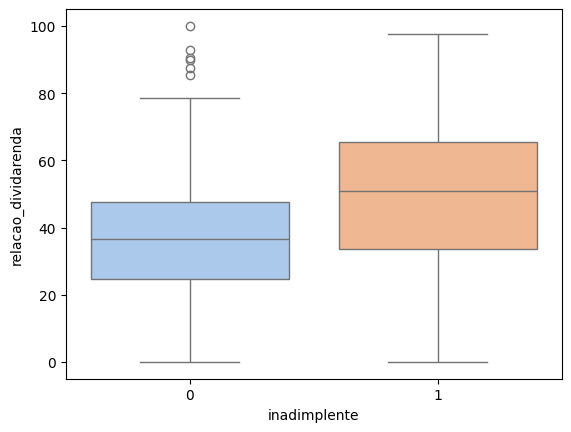

In [31]:
sns.boxplot(x="inadimplente", y="relacao_dividarenda", hue="inadimplente", data=df, palette="pastel", legend=False)

It is possible to verify that non-defaulters have a lower debt/income ratio. Care must be taken with variables of this type, because if it is considered after we know whether the customer was in default or not, data leakage may occur.

Therefore, we will consider that this feature was collected BEFORE we granted the credit.

* **Amount of loan granted to the customer vs Default**

<Axes: xlabel='inadimplente', ylabel='valor_emprestimo'>

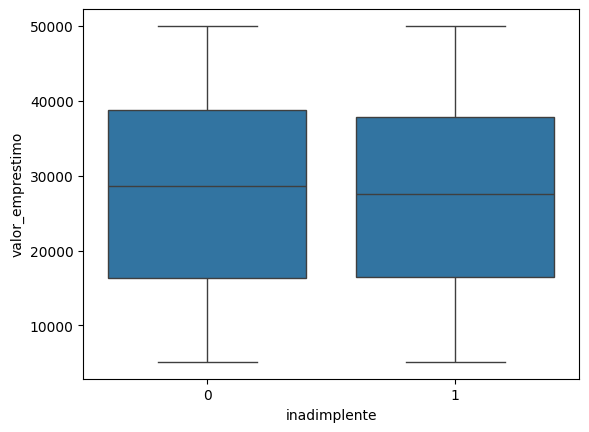

In [32]:
sns.boxplot(data=df, x='inadimplente', y='valor_emprestimo')

There is no significant difference


### **2.3- Hypothesis tests**

We want to use the hypothesis test to verify the following questions about the population.

1.   Do clients with higher performance have a higher score?
2.   Do clients with lower salaries have a shorter period of default?
3.   Does the work class impact the customer's average score?



#### **2.3.1- Do clients with higher salary have a higher score?**

*  **Checking about the variance.**

1. `Ho`: variances are equal
2. `Ha`: some of variances sample are differents

To check it we will run a Levene test.

In [33]:
# Grupo by Score by salary range
grupos = df.groupby('faixa_valor', observed=False)['Score'].apply(list).tolist()

# levene test
stat_levene, p_levene = levene(*grupos)
print(f"🔎 Levene Test — stat = {stat_levene:.3f}, p_value = {p_levene:.4f}\n")

if p_levene > 0.05:
    print(f"✅ {p_levene:.3f} > 0.05: you can assume the variances are equal and proceed with traditional ANOVA")

else:
    print("⚠️ Variances are significantly different — better to use Welch ANOVA or Kruskal-Wallis.")



🔎 Levene Test — stat = 0.977, p_value = 0.4029

✅ 0.403 > 0.05: you can assume the variances are equal and proceed with traditional ANOVA


✅ **Hypothesis testing: ANOVA (Analysis of Variance)**

**Hypothesis**

1. H₀ (null): all salary ranges have the same average score.

2. H₁ (alternative): at least one band has a different average.

In [34]:

f_stat, p_val = f_oneway(*grupos)

print(f'🔎 ANOVA Test- stats = {f_stat:.3f}, p_value = {p_val:.4f}\n')

if p_val < 0.05:
    print('⚠️ Reject the null hypothesis. At least one band has a different average ')
else:
    print('✅ Fail to reject the null hypothesis. You can assume all salary ranges have the same average score')


🔎 ANOVA Test- stats = 0.584, p_value = 0.6257

✅ Fail to reject the null hypothesis. You can assume all salary ranges have the same average score


#### **2.3.2- Do clients with lower salaries have a shorter period of default?**

In [35]:
# Grupo by Score by salary range
grupos = df.groupby('faixa_valor', observed=False)['hist_inadim_meses'].apply(list).tolist()

# levene test
stat_levene, p_levene = levene(*grupos)
print(f"🔎 Levene Test — stat = {stat_levene:.3f}, p_value = {p_levene:.4f}\n")

if p_levene > 0.05:
    print(f"✅ {p_levene:.3f} > 0.05: you can assume the variances are equal and proceed with traditional ANOVA")

else:
    print("⚠️ Variances are significantly different — better to use Welch ANOVA or Kruskal-Wallis.")

🔎 Levene Test — stat = 1.011, p_value = 0.3869

✅ 0.387 > 0.05: you can assume the variances are equal and proceed with traditional ANOVA


✅ **Hypothesis testing: ANOVA (Analysis of Variance)**

**Hypothesis**

1. H₀ (null): all salary ranges have the same average of months of default.

2. H₁ (alternative): at least one band has a different average of months of default.

In [36]:
f_stat, p_val = f_oneway(*grupos)

print(f'🔎 ANOVA Test- stats = {f_stat:.3f}, p_value = {p_val:.4f}\n')

if p_val < 0.05:
    print('⚠️ Reject the null hypothesis. At least one band has a different average of months of default')
else:
    print('✅ Fail to reject the null hypothesis. You can assume all salary ranges have the same average of months of default ')

🔎 ANOVA Test- stats = 1.484, p_value = 0.2174

✅ Fail to reject the null hypothesis. You can assume all salary ranges have the same average of months of default 


#### **2.3.3- Does the work class impact the customer's average score?**

*  **Checking about the variance.**

1. `Ho`: variances are equal
2. `Ha`: some of variances sample are differents

To check it we will run a Levene test.

In [37]:
# Grupo by Score by salary range
grupos = df.groupby('classe_emprego', observed=False)['Score'].apply(list).tolist()

# levene test
stat_levene, p_levene = levene(*grupos)
print(f"🔎 Levene Test — stat = {stat_levene:.3f}, p_value = {p_levene:.4f}\n")

if p_levene > 0.05:
    print(f"✅ {p_levene:.3f} > 0.05: you can assume the variances are equal and proceed with traditional ANOVA")

else:
    print("⚠️ Variances are significantly different — better to use Welch ANOVA or Kruskal-Wallis.")


🔎 Levene Test — stat = 1.094, p_value = 0.3354

✅ 0.335 > 0.05: you can assume the variances are equal and proceed with traditional ANOVA


✅ **Hypothesis testing: ANOVA (Analysis of Variance)**

**Hypothesis**

1. H₀ (null): all the type of employment have the same average of score.

2. H₁ (alternative): at least one band has a different average of score.

In [38]:
f_stat, p_val = f_oneway(*grupos)

print(f'🔎 ANOVA Test- stats = {f_stat:.3f}, p_value = {p_val:.4f}\n')

if p_val < 0.05:
    print('⚠️ Reject the null hypothesis. At least one band has a different average of score')
else:
    print('✅ Fail to reject the null hypothesis. You can assume all the type of employment have the same average of score ')

🔎 ANOVA Test- stats = 1.372, p_value = 0.2540

✅ Fail to reject the null hypothesis. You can assume all the type of employment have the same average of score 


## **3- Building a Machine Learning Model**

### **3.1- Pre-Processsing**

In [39]:
# transforming categorical features in numerical
df_original = pd.get_dummies(df_original, columns=['classe_emprego'], dtype= int)

In [40]:
df_original

,Idade,Renda,Score,hist_inadim_meses,valor_emprestimo,relacao_dividarenda,possui_imovel,possui_veiculo,inadimplente,classe_emprego_Autônomo,classe_emprego_CLT,classe_emprego_Desempregado
0,56,7882,520,1,32586,55.29,1,0,0,0,1,0
1,69,2906,453,10,22568,15.18,1,0,1,0,1,0
2,46,4086,311,5,25810,9.28,0,0,1,0,0,1
3,32,14503,432,11,6551,61.81,0,1,1,1,0,0
4,60,9152,603,5,17625,25.59,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,60,13040,816,10,27553,47.56,0,0,0,0,1,0
996,64,10218,463,1,29366,31.16,1,0,0,1,0,0
997,62,7471,363,7,49036,66.42,0,0,1,0,1,0
998,35,3863,390,10,22369,1.91,1,0,1,1,0,0


In [41]:
# slipt dataframe in train and test

X = df_original.drop('inadimplente', axis=1)
y = df_original['inadimplente']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)


In [42]:
#checking the train and test sizes
print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_test.shape}')

X_train size: (800, 11)
X_test size: (200, 11)


We will apply MinMax Scaler because the features don't follow a normal distribution. So when we apply this kind of scaler, we transform the scale, between 0 and 1, but keep the distribution shape.

In [43]:
#applying the MinMax Scaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **3.2 - Models**

#### **3.2.1- Logistic Regression**

In [44]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [45]:
#making prediction
y_pred = logistic_model.predict(X_test_scaled)

In [46]:
#model evaluate
y_logistic_proba = logistic_model.predict_proba(X_test_scaled)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_logistic_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


ROC-AUC: 0.8657166029428802
Accuracy: 0.785
Precision: 0.7272727272727273
Recall: 0.5079365079365079

Confusion Matrix:
 [[125  12]
 [ 31  32]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       137
           1       0.73      0.51      0.60        63

    accuracy                           0.79       200
   macro avg       0.76      0.71      0.73       200
weighted avg       0.78      0.79      0.77       200



**Precision:**
Of all the cases that the model said it was class 1, 73% were correct.

**Recall:**
Of all the cases that were actually class 1, the model only found 51%.

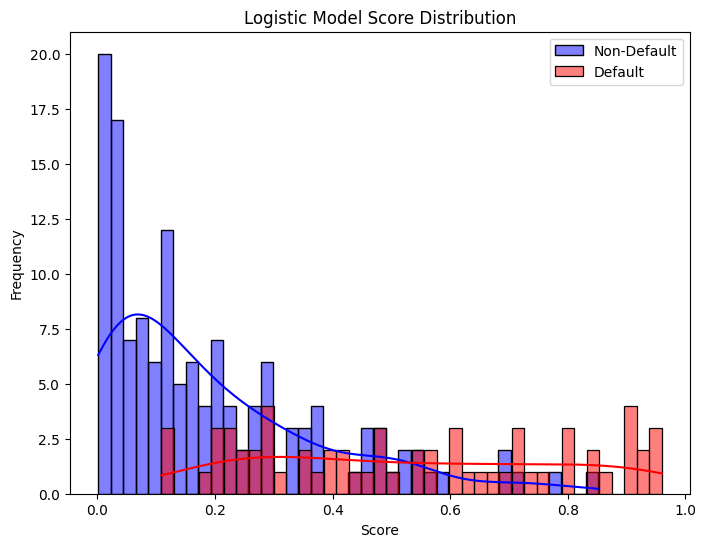

In [47]:
df_scores = pd.DataFrame({'Logistic_Score': y_logistic_proba, 'Class': y_test})

plt.figure(figsize=(8,6))

sns.histplot(df_scores[df_scores['Class']==0]['Logistic_Score'], bins=40, color='blue', label='Non-Default', kde=True, alpha=0.5)
sns.histplot(df_scores[df_scores['Class']==1]['Logistic_Score'], bins=40, color='red', label='Default', kde=True, alpha=0.5)

plt.title("Logistic Model Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [48]:
df_original['inadimplente'].value_counts()

inadimplente
0    687
1    313
Name: count, dtype: int64

The model is predicting class 1 customers very poorly. It is possible to see from both the metrics and the graph that its recall is very low, that is, of all the customers who were actually in default, it was only able to correctly predict 51%. This may be due to class imbalance. Therefore, we will retrain the model including class balancing.

ROC-AUC: 0.867686247248291
Accuracy: 0.77
Precision: 0.6197183098591549
Recall: 0.6984126984126984

Confusion Matrix:
 [[110  27]
 [ 19  44]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83       137
           1       0.62      0.70      0.66        63

    accuracy                           0.77       200
   macro avg       0.74      0.75      0.74       200
weighted avg       0.78      0.77      0.77       200



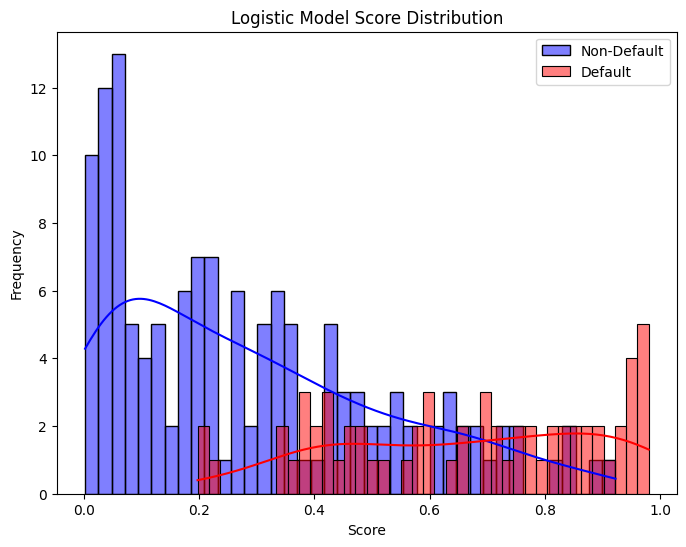

In [49]:
# adjusting the Logistic Regression with class weight
logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logistic_model.fit(X_train_scaled, y_train)

#make predictions
y_logistic_pred = logistic_model.predict(X_test_scaled)
y_logistic_proba = logistic_model.predict_proba(X_test_scaled)[:,1]

#store results in a dataframe
df_scores= pd.DataFrame({'Logistic_Score': y_logistic_proba, 'Class': y_test})

# print all metrics
print("ROC-AUC:", roc_auc_score(y_test, y_logistic_proba))
print("Accuracy:", accuracy_score(y_test, y_logistic_pred))
print("Precision:", precision_score(y_test, y_logistic_pred))
print("Recall:", recall_score(y_test, y_logistic_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_logistic_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_logistic_pred))

#check the distribution plot
plt.figure(figsize=(8,6))

sns.histplot(df_scores[df_scores['Class']==0]['Logistic_Score'], bins=40, color='blue', label='Non-Default', kde=True, alpha=0.5)
sns.histplot(df_scores[df_scores['Class']==1]['Logistic_Score'], bins=40, color='red', label='Default', kde=True, alpha=0.5)

plt.title("Logistic Model Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()



Now, you can see that there is a good improvement in our model. We have managed to improve the recall metrics and the ROC-AUC is also better.

#### **3.2.2- Decision Tree**

In [50]:
#fit the model
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
tree.fit(X_train_scaled, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


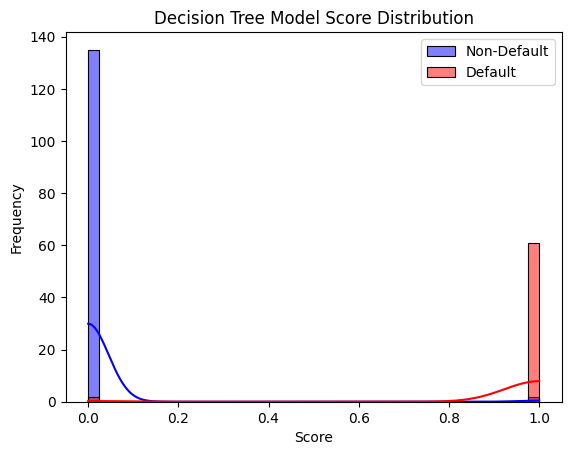

ROC-AUC: 0.9768277140539915
Accuracy: 0.98
Precision: 0.9682539682539683
Recall: 0.9682539682539683

Confusion Matrix:
 [[135   2]
 [  2  61]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.97      0.97      0.97        63

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [51]:
# making predictions
y_tree_pred = tree.predict(X_test_scaled)
y_tree_proba = tree.predict_proba(X_test_scaled)[:,1]

#saving scores in a datframe
df_scores['Tree_Score'] = y_tree_proba

# plot the scores distribution
sns.histplot(df_scores[df_scores['Class']==0]['Tree_Score'], bins=40, color='blue', label='Non-Default', kde=True, alpha=0.5)
sns.histplot(df_scores[df_scores['Class']==1]['Tree_Score'], bins=40, color='red', label='Default', kde=True, alpha=0.5)

plt.title("Decision Tree Model Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# print all metrics
print("ROC-AUC:", roc_auc_score(y_test, y_tree_proba))
print("Accuracy:", accuracy_score(y_test, y_tree_pred))
print("Precision:", precision_score(y_test, y_tree_pred))
print("Recall:", recall_score(y_test, y_tree_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_tree_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_tree_pred))

These metrics indicate that an overfit may have occurred.To avoid this problem, we will do some hyperparameter tuning and analyze the feature importance.

* **Hyperparameter Tuning**

In [52]:
#defining hyperpatameter to be adjusted
param_grid = {
    'max_depth': Integer(3,15),
    'min_samples_split': Integer(2,10),
    'min_samples_leaf': Integer(1,20),
    'max_features': Categorical([None, 'sqrt', 'log2'])
}

#Inicialize teh model
tree = DecisionTreeClassifier(random_state=42)

#setup the BayesSearchCV
bayes_search = BayesSearchCV(
    estimator= tree,
    search_spaces =param_grid,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

#adjust the model into data
bayes_search.fit(X_train_scaled, y_train)

#print the best parameters
print("Best Parameters:", bayes_search.best_params_)
print("Melhor pontuação ROC-AUC:", bayes_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

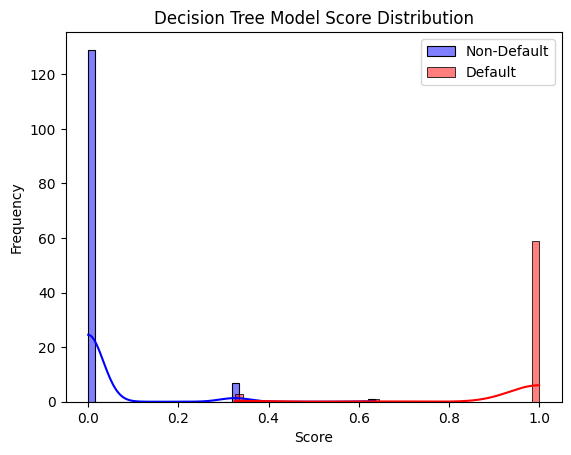

ROC-AUC: 0.9983779399837793
Accuracy: 0.98
Precision: 0.9836065573770492
Recall: 0.9523809523809523

Confusion Matrix:
 [[136   1]
 [  3  60]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       137
           1       0.98      0.95      0.97        63

    accuracy                           0.98       200
   macro avg       0.98      0.97      0.98       200
weighted avg       0.98      0.98      0.98       200



In [53]:
# Model training
best_tree = DecisionTreeClassifier( **bayes_search.best_params_, random_state=42)
best_tree.fit(X_train_scaled, y_train)

#making predictions~
y_tree_pred = best_tree.predict(X_test_scaled)
y_tree_proba = best_tree.predict_proba(X_test_scaled)[:,1]

#saving results into a datframe
df_scores['Best_Tree_Score'] = y_tree_proba

# plot the scores distribution
sns.histplot(df_scores[df_scores['Class']==0]['Best_Tree_Score'], bins=40, color='blue', label='Non-Default', kde=True, alpha=0.5)
sns.histplot(df_scores[df_scores['Class']==1]['Best_Tree_Score'], bins=40, color='red', label='Default', kde=True, alpha=0.5)

plt.title("Decision Tree Model Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#print all metrics
print("ROC-AUC:", roc_auc_score(y_test, y_tree_proba))
print("Accuracy:", accuracy_score(y_test, y_tree_pred))
print("Precision:", precision_score(y_test, y_tree_pred))
print("Recall:", recall_score(y_test, y_tree_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_tree_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_tree_pred))


This is a really good model. We could find one that the precision and recall are balanced, with a great ROC-AUC value, almost 100%.